# SpatioTemporal Asset Catalogue (STAC)

[SpatioTemporal Asset Catalog (STAC)](https://stacspec.org/) is a specification that consistently describes geospatial information so it can more easily be discovered and accessed. 
STAC provides a powerful tool to quickly identify all available data for a given product, location or time period. 
This data can then be easily and efficiently loaded into your own computing environment, or streamed directly into desktop GIS software like QGIS or ESRI.

This tutorial demonstrates how to use the [odc-stac](https://odc-stac.readthedocs.io/en/latest/) Python package to load data from DEA using the DEA Explorer STAC API. The `odc-stac` package translates STAC metadata to the [Open Data Cube](https://www.opendatacube.org/) data model, allowing you to load DEA data into `xarray.Dataset` format to be processed locally, or distribute data loading and computation with [Dask](/notebooks/Beginners_guide/09_Parallel_processing_with_Dask/).
This approach is particularly useful for accessing data outside of DEA's managed [Sandbox](/guides/setup/Sandbox/sandbox/) or [NCI](/guides/setup/NCI/README/) environments.

For further information on how to use `odc-stac`, have a look at the [developer guide](https://odc-stac.readthedocs.io/en/latest/examples.html).

## Setup
Import required packages for querying and loading data from STAC:

In [1]:
import pystac_client
import odc.stac

Connect to the DEA Explorer STAC API to allow searching for data:

In [2]:
catalog = pystac_client.Client.open("https://explorer.dea.ga.gov.au/stac")

To load data via STAC, we must configure appropriate access to data stored on DEA's Amazon S3 buckets. 
This can be done with the [odc.stac.configure_rio](https://odc-stac.readthedocs.io/en/latest/_api/odc.stac.configure_rio.html#odc.stac.configure_rio) function.
The configuration below must be used when loading any DEA data through the STAC API.

In [3]:
odc.stac.configure_rio(
    cloud_defaults=True,
    aws={"aws_unsigned": True},
)

## Searching for STAC data using `pystac_client`
First we need to define the location, time period and DEA product we want to load. 

In this example, we will load December 2021 Landsat 8 data over Canberra:

In [4]:
# Set a bounding box
# [xmin, ymin, xmax, ymax] in latitude and longitude
bbox = [149.05, -35.32, 149.17, -35.25]

# Set a start and end date
start_date = "2021-12-01"
end_date = "2021-12-31"

# Set product ID as the STAC "collection"
collections = ["ga_ls8c_ard_3"]

Now we can use the `pystac_client` Python package to search for STAC items that match our query:

In [5]:
# Build a query with the parameters above
query = catalog.search(
    bbox=bbox,
    collections=collections,
    datetime=f"{start_date}/{end_date}",
)

# Search the STAC catalog for all items matching the query
items = list(query.items())
print(f"Found: {len(items):d} datasets")

Found: 8 datasets


## Loading data using `odc-stac`
Once we have found data to load, we can use the `odc.stac.load()` function to load them as `xarray.Dataset` format.

This works similarly to how the `datacube.load()` function is used to load data from DEA on the DEA Sandbox and on the NCI.

In [6]:
ds = odc.stac.load(
    items,
    bands=("nbart_red"),
    crs="EPSG:32655",
    resolution=30,
    chunks={},
    groupby="solar_day",
    bbox=bbox,
)

ds

<xarray.Dataset> Size: 2MB
Dimensions:      (y: 268, x: 370, time: 4)
Coordinates:
  * y            (y) float64 2kB -3.903e+06 -3.903e+06 ... -3.911e+06 -3.911e+06
  * x            (x) float64 3kB 6.864e+05 6.864e+05 ... 6.974e+05 6.974e+05
    spatial_ref  int32 4B 32655
  * time         (time) datetime64[ns] 32B 2021-12-04T23:50:39.744022 ... 202...
Data variables:
    nbart_red    (time, y, x) float32 2MB dask.array<chunksize=(1, 268, 370), meta=np.ndarray>

We can now plot and analyse our data:

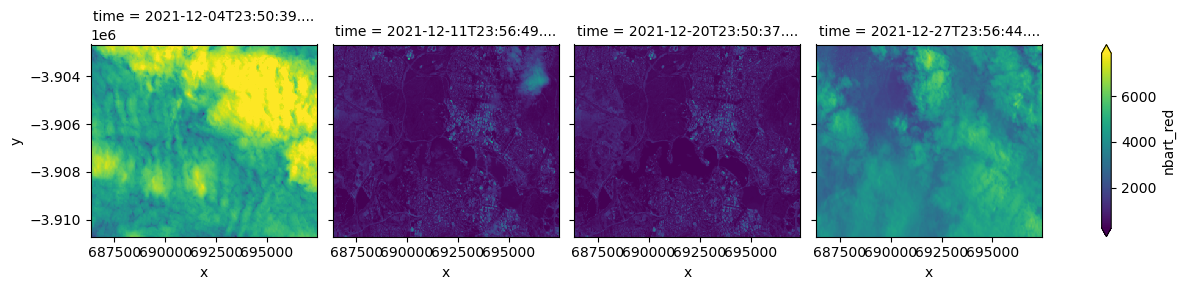

In [7]:
ds.nbart_red.plot(col="time", robust=True);

### Advanced data loading and filtering
The DEA STAC API supports advanced functionality for filtering data before loading it. 
For example, we can filter to load only mostly cloud free observations (e.g. less than 10% cloud) using the `filter` parameter.

For more information about using `filter`, refer to the [STAC guide here](https://pystac-client.readthedocs.io/en/stable/tutorials/cql2-filter.html).


Found: 3 datasets


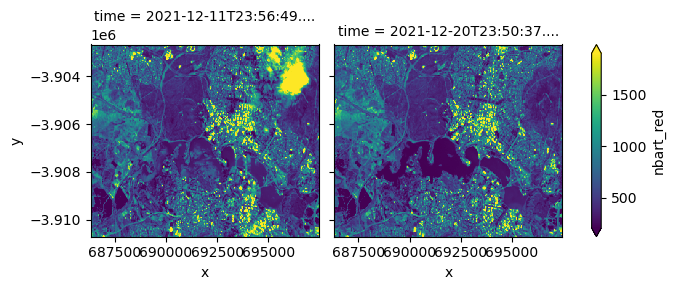

In [8]:
# Set up a filter query
filter_query = "cloud_cover < 10"

# Build a query with the set parameters
query = catalog.search(
    bbox=bbox,
    collections=collections,
    datetime=f"{start_date}/{end_date}",
    filter=filter_query,
)

# Search the STAC catalog for all items matching the query
items = list(query.items())
print(f"Found: {len(items):d} datasets")

# Load our filtered data
ds_filtered = odc.stac.load(
    items,
    bands=("nbart_red"),
    crs="EPSG:32655",
    resolution=30,
    chunks={},
    groupby="solar_day",
    bbox=bbox,
)

# Plot our filtered data
ds_filtered.nbart_red.plot(col="time", robust=True);

## Additional resources

Explore the following Jupyter Notebooks for more in-depth guides to querying and loading data from STAC:
* [Downloading and streaming data using STAC](/notebooks/How_to_guides/Downloading_data_with_STAC/)
* [Combining data from DEA and Microsoft Planetary Computer](/notebooks/How_to_guides/Planetary_computer/)